# Simple Hidden States with Numpy

jhbale11

[Coursera]Andrew Ng 's Deep Learning Lecture

https://github.com/suqi/deeplearning_andrewng

앤드류 응 교수님의 딥러닝 강의를 듣고 예제를 제 방식대로 연습한 결과입니다.

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from utils_123 import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

## 1. Load Data

In [2]:
X, Y = load_planar_dataset()
X.shape, Y.shape # (feature, sample size), (label, sample size)

((2, 400), (1, 400))

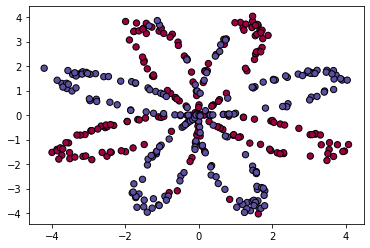

In [3]:
# 시각화
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral, edgecolor='k');

위와 같이 꽃무늬 모양으로 Scatter Plot이 그려진 것을 확인할 수 있습니다.

X[0,:]과 X[1, :]의 관계가 선형이 아니므로 기존의 Logestic Regression을 적용하기 어려울 것입니다.

## 2. Simple Logistic Regression

사이킷런을 사용하여 간단한 로지스틱 회귀를 구현해보겠습니다.

In [4]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs')
clf.fit(X.T, Y.ravel());
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' 
       % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
    "%")

Accuracy of logistic regression: 47 %


선형의 관계가 아니므로 Accuracy가 47% 입니다.

이런 경우 분류 성능을 높이기 위해서는 Logestic Regression이 아닌 다른 방법이 필요합니다.

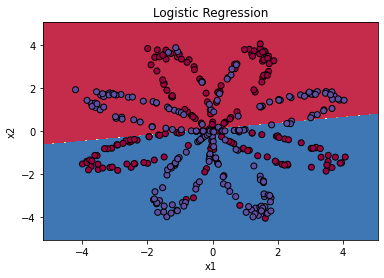

In [5]:
# 로지스틱 회귀의 결정 경계 시각화
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")
plt.show()

## 3. Neural Network model

은닉층이 하나 있는 신경망을 만들어볼 것입니다.

**만들고자 하는 모델**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**필요한 수학 공식**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

손실함수 $J$: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

먼저 보조 함수를 정의하고 `nn_model()`에 합칠 것입니다. 

필요한 보조함수 목록은 아래와 같습니다.
- layer_sizes : 각 층의 출력 크기를 반환하는 함수
- initialize_parameters : 가중치 값을 초기화하는 함수
- forward_propagation : 순전파 함수
- compute_cost : Loss를 계산하는 함수
- backward_propagation : 역전파 함수
- update_parameter : 파라미터를 업데이트해주는 함수

In [6]:
# 우선 각 층의 출력 크기를 반환하는 함수를 정의한다. 은닉층의 크기는 4로 한다.
def layer_sizes(X, Y):
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    return n_x, n_h, n_y

# 가중치 값 초기화
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    W2 = np.random.randn(n_y, n_h) * 0.01
    b1 = np.zeros((n_h,1))
    b2 = np.zeros((n_y,1))
    parameters = {
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2
    }
    return parameters

# 순전파 함수. 역전파에 필요한 값을 cache에 담아서 반환
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    A1 = np.tanh(np.dot(W1, X) + b1)
    A2 = sigmoid(np.dot(W2, A1) + b2)
    cache = {"A1": A1,
             "A2": A2}
    return A2, cache

# 손실값 계산
def compute_cost(A2, Y):
    m = Y.shape[1] # number of example
    cost = -np.sum(np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)) / m
    return cost

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->


In [7]:
# 그래디언트 계산
def backward_propagation(parameters, cache, X, Y):
    
    m = X.shape[1]
    W1 = parameters["W1"] 
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) /m
    
    dZ1 = np.dot(W2.T, dZ2) * (1 - A1**2)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) /m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    return grads

def update_parameters(parameters, grads, learning_rate = 1.2):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    b1 -= learning_rate * db1
    b2 -= learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

위의 보조함수들을 합쳐 모델을 만들겠습니다.

1) 파라미터를 초기화한 후,

2) 순전파를 통해 A와 Cache를 얻고,

3) 역전파를 통해 grads를 얻습니다.

In [8]:
# 보조 함수들을 합쳐서 모델을 만든다.
def nn_model(X, Y, n_h, X_val=None, Y_val=None, num_iterations = 10000, learning_rate=1.2):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    global costs
    global val_costs
    costs = []
    val_costs = []
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        costs.append(compute_cost(A2, Y))
        
        try:
            val_A2, val_cache = forward_propagation(X_val, parameters)
            val_costs.append(compute_cost(val_A2, Y_val))
        except:
            pass
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)
    return parameters

prediction이 0.5를 넘는 경우 1을 그렇지 않은 경우 0을 출력하는 prediction 함수를 정의합니다.

In [9]:
# 예측 함수
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = np.where(A2 > 0.5, 1, 0)
    return predictions

In [10]:
params = nn_model(X, Y, n_h=4, num_iterations=10000, learning_rate=1.2)
pred = predict(params, X)
print('Accuracy:', ((np.sum(pred * Y)+np.sum((1-pred)*(1-Y))) / Y.size) * 100, '%')

Accuracy: 90.75 %


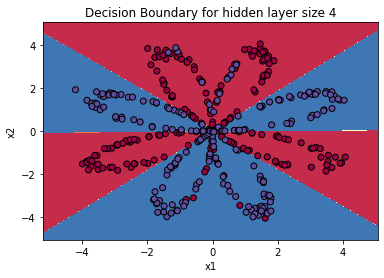

In [11]:
plot_decision_boundary(lambda x: predict(params, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
plt.show()

**설명:** 로지스틱 회귀에 비해 정확도가 크게 개선되었다.
신경망은 매우 비선형적인 결정 경계를 만들 수도 있다.

### 4. Tuning hidden layer size ###

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 90.5 %
Accuracy for 20 hidden units: 91.25 %
Accuracy for 50 hidden units: 91.0 %


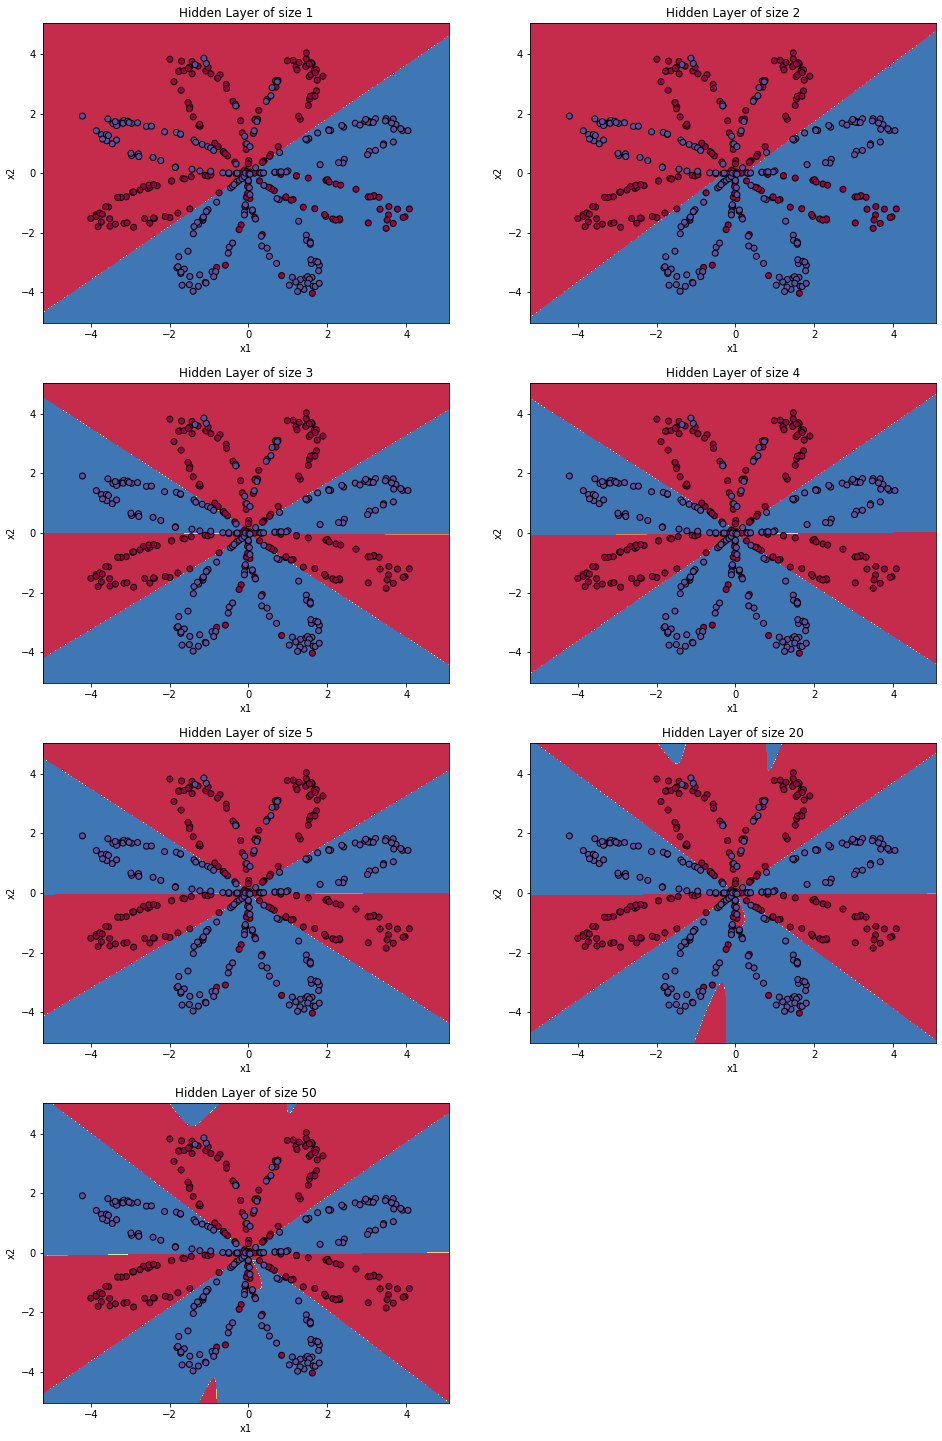

In [12]:
# 은닉층이 많아질수록 정확도가 향상되나, 일정 수준 이상에서는 더 이상 성능이 향상되지 않는다.
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

- 은닉층의 개수가 많아지면 데이터에 더 잘 적합되며, 결국 과적합이 일어납니다.
- 정규화 기법 등을 통해 은닉층의 개수를 크게 하면서 과적합을 막을 수 있습니다. 

## 5. Performance on other datasets

이제 다른 데이터에도 위에서 구현한 모델을 시험해보겠습니다.

모델이 빨간 점과 파란 점을 잘 분류하고 있는지 시각적으로 확인할 수 있습니다.

Accuracy: 97.5 %


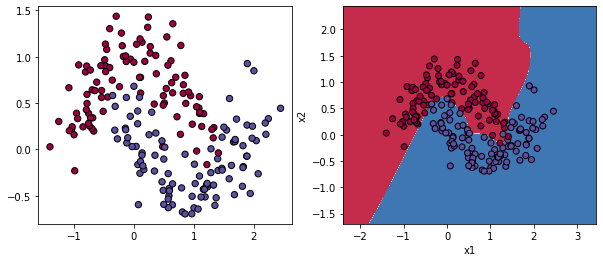

In [13]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()
X, Y = noisy_moons
X, Y = X.T, Y.reshape(1, Y.shape[0])

params = nn_model(X, Y, n_h=10, num_iterations=10000, learning_rate=1.2)
pred = predict(params, X)
print('Accuracy:', ((np.sum(pred * Y)+np.sum((1-pred)*(1-Y))) / Y.size) * 100, '%')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral, edgecolor='k')
plt.subplot(122)
plot_decision_boundary(lambda x: predict(params, x.T), X, Y)

data shape: (2, 200) (1, 200)
Accuracy: 85.0 %


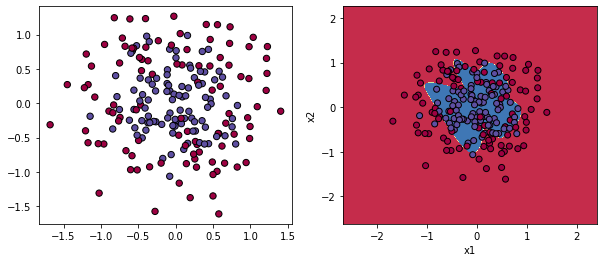

In [14]:
X, Y = noisy_circles
X, Y = X.T, Y.reshape(1, Y.shape[0])
print('data shape:', X.shape, Y.shape)

params = nn_model(X, Y, n_h=10, num_iterations=10000, learning_rate=1.2)
pred = predict(params, X)
print('Accuracy:', ((np.sum(pred * Y)+np.sum((1-pred)*(1-Y))) / Y.size) * 100, '%')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral, edgecolor='k')
plt.subplot(122)
plot_decision_boundary(lambda x: predict(params, x.T), X, Y)

data shape: (2, 200) (1, 200)
Accuracy: 100.0 %


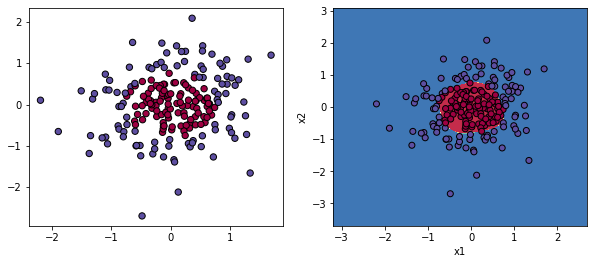

In [15]:
X, Y = gaussian_quantiles
X, Y = X.T, Y.reshape(1, Y.shape[0])
print('data shape:', X.shape, Y.shape)

params = nn_model(X, Y, n_h=10, num_iterations=10000, learning_rate=1.2)
pred = predict(params, X)
print('Accuracy:', ((np.sum(pred * Y)+np.sum((1-pred)*(1-Y))) / Y.size) * 100, '%')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral, edgecolor='k')
plt.subplot(122)
plot_decision_boundary(lambda x: predict(params, x.T), X, Y)

## 숫자 이미지 분류

In [16]:
from sklearn.datasets import load_digits # 전처리 과정은 1장과 동일.
data = load_digits()
data_x, data_y = data['images'], data['target']
index = np.random.permutation(data_x.shape[0])
data_x_shuffled = data_x[index]
data_y_shuffled = data_y[index]
data_x_flattend = data_x_shuffled.reshape(-1,8*8).T / 16
data_y_flattend = data_y_shuffled.reshape(1,-1)
data_y_flattend_binary = np.where(data_y_flattend%2==0,0,1)
test_size = round(data_x_flattend.shape[1] * 0.2)
X_train = data_x_flattend[:, test_size:] 
X_test = data_x_flattend[:, :test_size] 
y_train = data_y_flattend_binary[:,test_size:]
y_test = data_y_flattend_binary[:,:test_size]

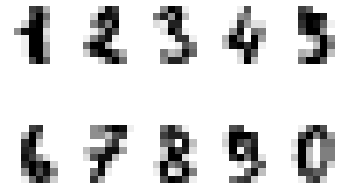

In [17]:
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(data_x[i], cmap='binary')
    plt.axis('off')
plt.show()

In [18]:
params = nn_model(X_train, y_train, n_h=10, X_val=X_test, Y_val=y_test, num_iterations=10000, learning_rate=0.8)
pred = predict(params, X_test)
print('Accuracy:', ((np.sum(pred * y_test)+np.sum((1-pred)*(1-y_test))) / y_test.size) * 100, '%')

Accuracy: 98.60724233983287 %


이전 장에서 단순 로지스틱 회귀를 했을 때 Accuracy는 test set에 대하여 91%였습니다.

은닉층을 추가한 경우 accuracy가 98.607%로 은닉층 없이 단순 로지스틱 회귀를 했을 때에 비해 성능이 크게 향상되었음을 확인할 수 있습니다.

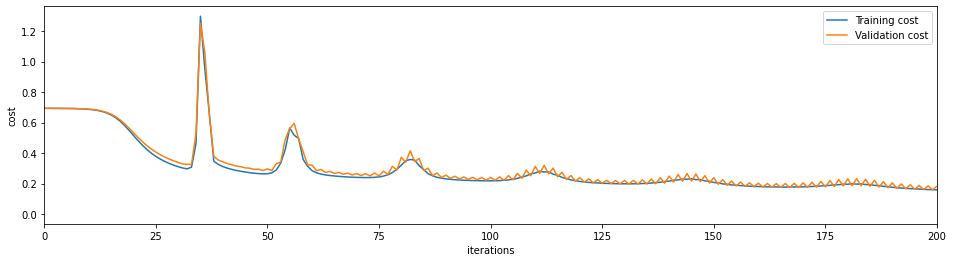

In [19]:
# 손실값을 그려보면 다음과 같습니다.
plt.figure(figsize=(16,4))
plt.plot(costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.legend()
plt.ylabel('cost')
plt.xlabel('iterations')
plt.xlim(0,200)
plt.show()